In [1]:
import sys

sys.path.append('../xor_neuron')

In [2]:
# %matplotlib inline
# # produce vector inline graphics
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
# import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

In [3]:
import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch
from scipy.signal import convolve2d, fftconvolve, convolve
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

from model import *
from utils.train_helper import save_outphase, make_mask, load_model

In [4]:
import torch.nn as nn

In [5]:
dirs = glob('../exp/Resnet20_1arg/*')
dirs.sort(key=os.path.abspath)
dirs

['../exp/Resnet20_1arg/resnet18_resnet18_cifar10_045657',
 '../exp/Resnet20_1arg/resnet18_resnet18_cifar10_082506',
 '../exp/Resnet20_1arg/resnet18_resnet18_cifar10_151617',
 '../exp/Resnet20_1arg/resnet18_resnet18_cifar10_184111']

In [6]:
epoch = np.arange(600)

[0.8695913461538461]
[0.09985977564102565]
[0.8793068910256411]
[0.8723958333333334]


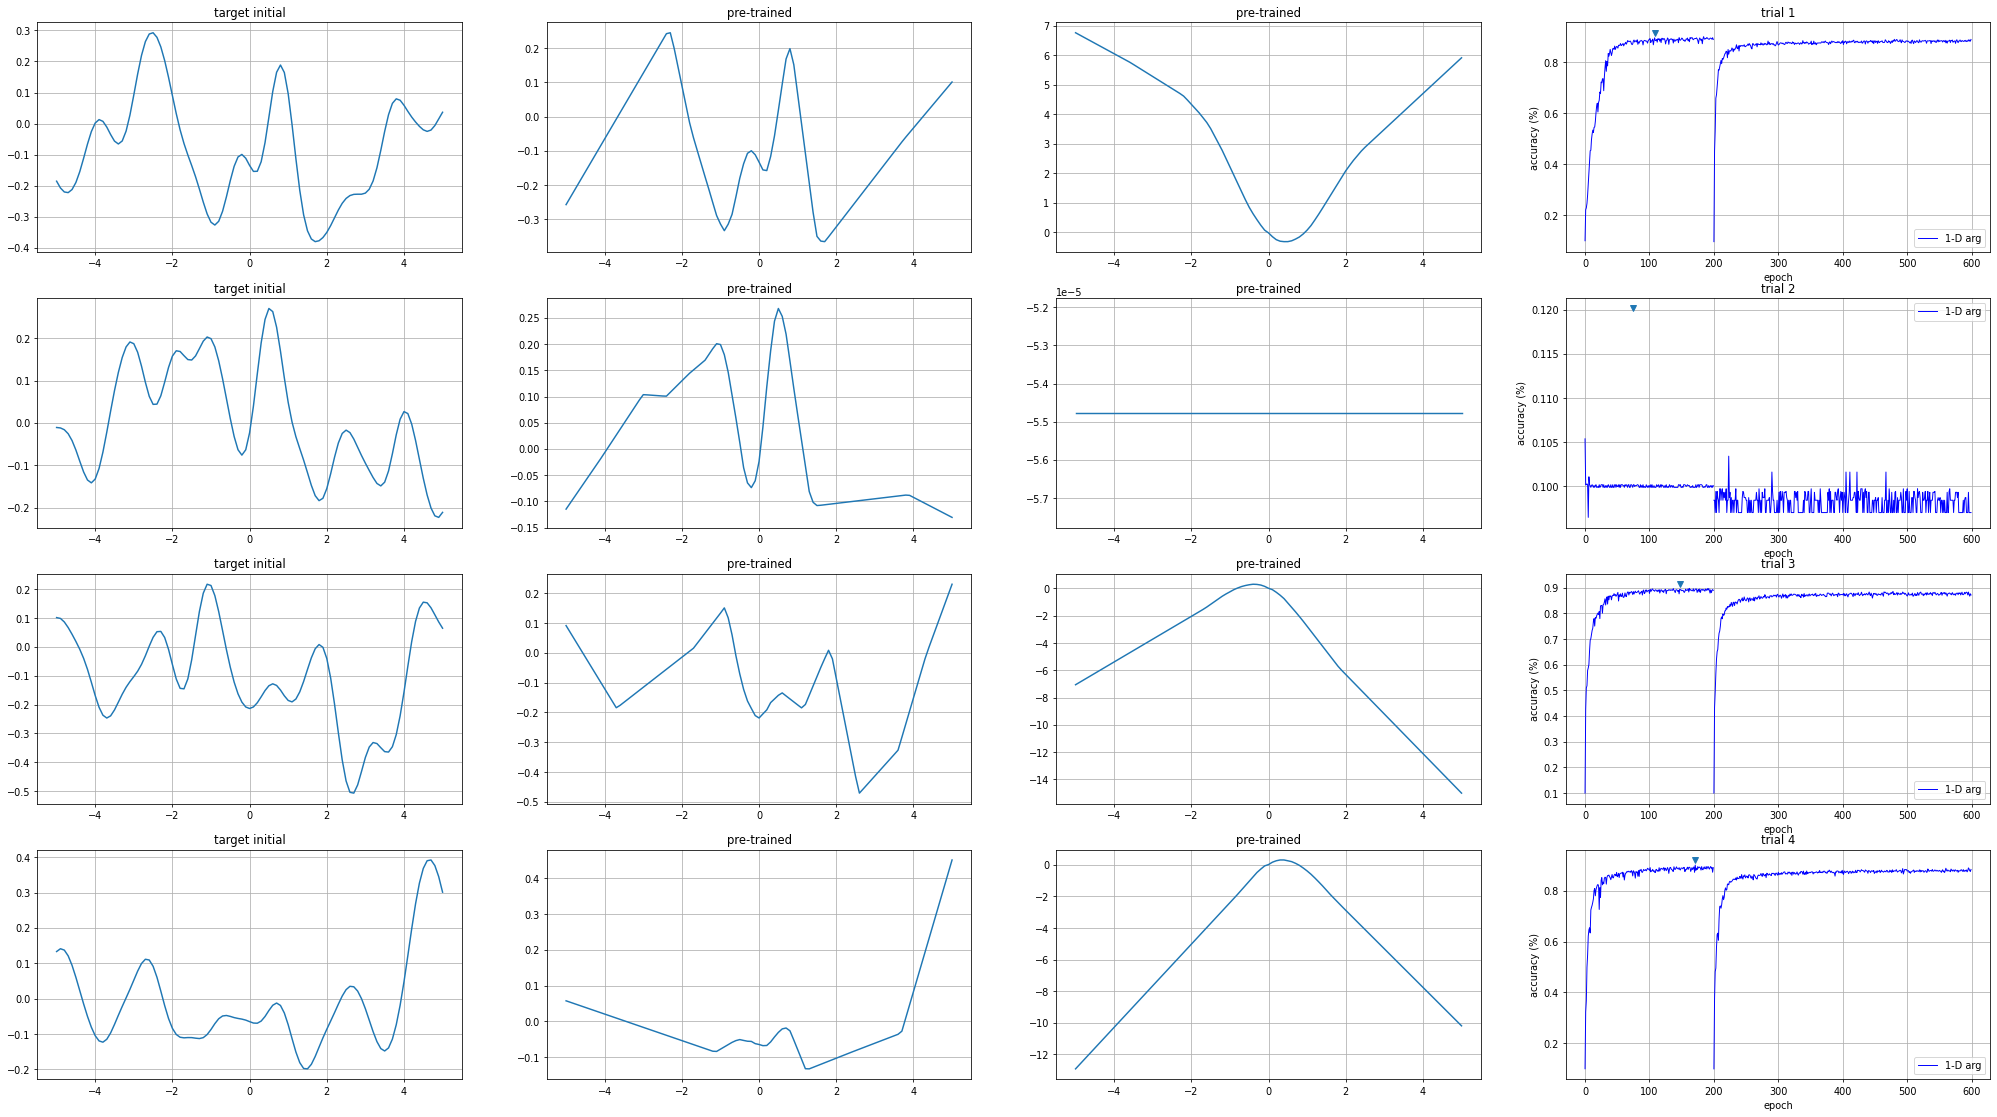

In [8]:
f, axes = plt.subplots(nrows=len(dirs), ncols=4, figsize=(36, 5*len(dirs)), dpi=70)

for ii, dr in enumerate(dirs):
    phase1_file = glob(dr + '/train_stats_phase1.p')[0]
    phase2_file = glob(dr + '/train_stats_phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
    phase2_data = pickle.load(open(phase2_file, 'rb'))
    target_file = glob(dr + '/pretrain_target.p')[0]
    targets = pickle.load(open(target_file, 'rb'))
    
        
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    best = 0
    for i in range(len(phase1_data['val_loss'])):
        if phase1_data['val_loss'][i] == phase1_data['best_val_loss']:
            best = i
            
        # ========== Column 6: Model Accuracy ==============
    axes[ii,3].plot(epoch[:200], phase1_data['val_acc'], 
                    'b', lw=1, label = '1-D arg')
    axes[ii,3].plot(epoch[200:], phase2_data['val_acc'], 
                    'b', lw=1)
    axes[ii,3].plot(best,phase1_data['val_acc'][best] + 0.02, 'v')
    axes[ii,3].set_xlabel('epoch')
    axes[ii,3].set_ylabel('accuracy (%)')
    
    if config.dataset.name == 'mnist':
        axes[ii,3].set_ylim(0.98,1)
    axes[ii,3].legend()

    axes[ii,3].set_title(f'trial {1+ii}')
    axes[ii,3].grid(True)
    
    
    nb = 101
    x = np.linspace(-5, 5, nb)
    mvn = multivariate_normal(mean=0, cov=1/4)
    gaussian_kernel = mvn.pdf(x).reshape(nb)
    gaussian_kernel /= gaussian_kernel.sum()
    
    # create models
    model_pretrain = InnerNet_V2(config)
    model_phase1 = InnerNet_V2(config)

    # load test model
    load_model(model_pretrain.inner_net, config.model_save + config.pretrain.best_model[0])
    load_model(model_phase1.inner_net, config.model_save + config.train.best_model)
    
    model_pretrain.eval()
    model_phase1.eval()
    
    x = x.reshape(-1,1)
    out_pretrain = model_pretrain.inner_net(torch.Tensor(x))
    out_phase1 = model_phase1.inner_net(torch.Tensor(x))
    
    out_pretrain = out_pretrain.reshape(-1,1)
    out_phase1 = out_phase1.reshape(-1,1)
    
    # ========== Column 2: Target Initial ==============
    im = axes[ii,0].plot(x.reshape(-1), targets.reshape(-1))
    axes[ii,0].set_title('target initial')
    axes[ii,0].grid(True)
    
    # ========== Column 3: Pre-trained  ==============
    im = axes[ii,1].plot(x.reshape(-1), out_pretrain.detach().reshape(-1))
    axes[ii,1].set_title('pre-trained')
    axes[ii,1].grid(True)
    
    # ========== Column 3: Pre-trained  ==============
    im = axes[ii,2].plot(x.reshape(-1), out_phase1.detach().reshape(-1))
    axes[ii,2].set_title('pre-trained')
    axes[ii,2].grid(True)
    
    print(phase1_data['best_val_acc'])
    
# plt.savefig(f'./ResNet18_1arg.png')
plt.show()